In [1]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import nltk
from nltk.corpus import stopwords
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.optimizers import Adam
from flask import Flask, request, jsonify
import joblib

# Download required NLTK data
nltk.download('stopwords')

# Load datasets
kaggle_train = pd.read_csv('/content/train.csv')
kaggle_test = pd.read_csv('/content/test.csv')
jigsaw_train = pd.read_csv('/content/sample_submission.csv')

# Create working copy
df = kaggle_train.copy()

# Text preprocessing functions
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stop_words = set(stopwords.words('english'))

def normalize_text(text):
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Apply preprocessing
df['clean_comment'] = df['comment_text'].apply(clean_text)
df.dropna(subset=['clean_comment'], inplace=True)
df['normalized_comment'] = df['clean_comment'].apply(normalize_text)
df['lemmatized_comment'] = df['normalized_comment'].apply(lemmatize_text)

# Prepare data for modeling
df['label'] = df['toxic']
X = df['lemmatized_comment']
y = df['label']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Before SMOTE: label
0    115421
1     12235
Name: count, dtype: int64
After SMOTE: label
0    115421
1    115421
Name: count, dtype: int64
Class weights: {0: 0.5530016201557776, 1: 5.21683694319575}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

998/998 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28856
           1       0.91      0.63      0.74      3059

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.96      0.96      0.95     31915

ROC-AUC: 0.809530293380901

SVM Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28856
           1       0.92      0.63      0.75      3059

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.96      0.96      0.96     31915

ROC-AUC: 0.8142628991899719

LSTM Report:
              precision    recall  f1-score   support

           0       0.95      0.02      0.05     28856
           1       0.10      0.99      0.18      3059

    accuracy                 

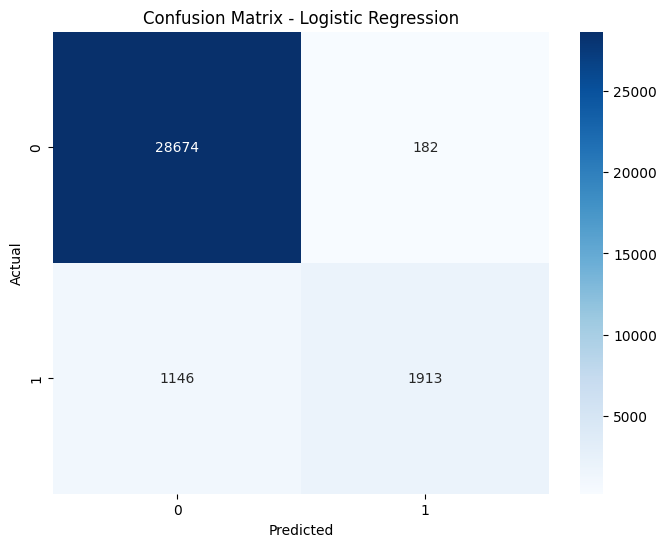

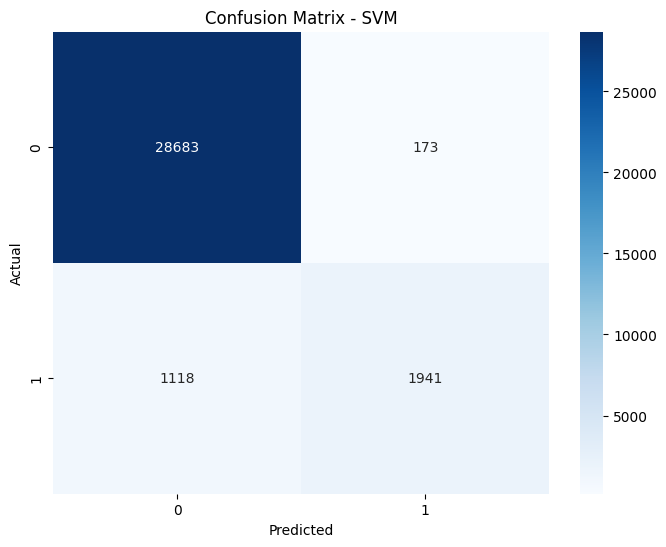

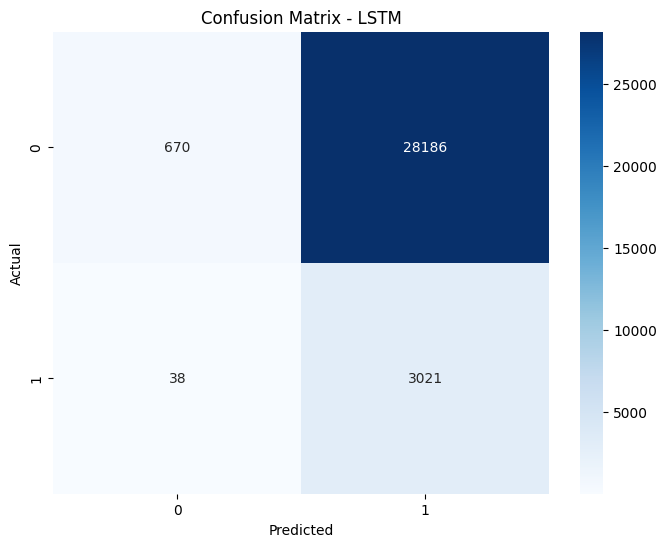

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
# Constants
MAX_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# BERT tokenization
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(texts, tokenizer, max_len=100):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

X_train_ids, X_train_masks = bert_encode(X_train, bert_tokenizer, MAX_SEQUENCE_LENGTH)
X_val_ids, X_val_masks = bert_encode(X_val, bert_tokenizer, MAX_SEQUENCE_LENGTH)

# Handle class imbalance
print("Before SMOTE:", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_padded, y_train)
print("After SMOTE:", pd.Series(y_train_balanced).value_counts())

# Compute class weights correctly
unique_classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)
class_weights = dict(zip(unique_classes, class_weights_array))
print("Class weights:", class_weights)

# LSTM model
embedding_dim = 128
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


# TF-IDF Vectorization for traditional models
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_val_tfidf)

# SVM
svm = SVC(probability=True)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_val_tfidf)

# LSTM Evaluation
y_pred_lstm = (model.predict(X_val_padded) > 0.5).astype("int32")

# Print evaluation metrics
print("Logistic Regression Report:")
print(classification_report(y_val, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_lr))

print("\nSVM Report:")
print(classification_report(y_val, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_svm))

print("\nLSTM Report:")
print(classification_report(y_val, y_pred_lstm))
print("ROC-AUC:", roc_auc_score(y_val, y_pred_lstm))

# Plotting functions
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_val, y_pred_lr, 'Confusion Matrix - Logistic Regression')
plot_confusion_matrix(y_val, y_pred_svm, 'Confusion Matrix - SVM')
plot_confusion_matrix(y_val, y_pred_lstm, 'Confusion Matrix - LSTM')

# Save models
model.save('lstm_model.h5')
joblib.dump(lr, 'logistic_regression_model.pkl')
joblib.dump(svm, 'svm_model.pkl')

# Flask API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    comment = data['comment']

    # Preprocess the comment
    clean = clean_text(comment)
    normalized = normalize_text(clean)
    lemmatized = lemmatize_text(normalized)

    # LSTM prediction
    seq = tokenizer.texts_to_sequences([lemmatized])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    lstm_pred = model.predict(padded)[0][0]

    # Logistic Regression prediction
    tfidf_vec = tfidf.transform([lemmatized])
    lr_pred = lr.predict_proba(tfidf_vec)[0][1]

    return jsonify({
        'lstm_prediction': float(lstm_pred),
        'lr_prediction': float(lr_pred),
        'toxic': bool(lstm_pred > 0.5 or lr_pred > 0.5)
    })

if __name__ == '__main__':
    app.run(debug=True)